In [1]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda import gpuarray, compiler
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from datetime import datetime


In [2]:
def printGPU():
    # Print available CUDA devices
    print("%d device(s) found." % cuda.Device.count())           
    for ordinal in range(cuda.Device.count()):
        dev = cuda.Device(ordinal)
        print("Device #%d: %s" % (ordinal, dev.name()))
    print(cuda)

In [3]:
def svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type):
    """Calculate the Sky View Factor on the GPU, incorporating vegetation transparency using asynchronous memory transfers."""

    px = np.array(dsm).astype(np.float32)
    veg_px = np.array(vegdem).astype(np.float32)
    veg_px2 = np.array(vegdem2).astype(np.float32)
    height, width = px.shape
    
    # Initialize CUDA stream
    stream = cuda.Stream()

    # Allocate memory on the GPU
    d_px = gpuarray.to_gpu(px)
    d_veg_px = gpuarray.to_gpu(veg_px)
    d_veg_px2 = gpuarray.to_gpu(veg_px2)
    d_out = gpuarray.empty((height, width), np.float32)

    # Define the CUDA kernel for SVF calculation
    kernel_code = """
    #include <math.h>
    #define PI 3.141592654
    __global__ void svfcalculator(float *lattice_out, float *lattice, float *veg_lattice, float *veg_lattice2, float scale, int width, int height, int svf_type) {
        int ix = threadIdx.x + blockIdx.x * blockDim.x;
        int iy = threadIdx.y + blockIdx.y * blockDim.y;
        if (ix >= width || iy >= height) return;

        int index = ix + iy * width;
        float clr00 = lattice[index];                                                                   // De hoogte van de dsm op dit punt
        float free_fraction_total = 0.0;

        // Verdeel in 360 graden voor thetaN (azimutale richting)
        for (int thetaN = 0; thetaN < 360; thetaN++) {
            float theta = PI * float(thetaN) / 180.0f;                                                  // Omgerekend naar radialen
            float free_fraction = 1.0f;                                                                 // Begin met een volledig vrije hemel

            // Verdeel de azimuth in gamma aantal stappen van 0 (horizon) naar gamma (zenith)
            int gamma_steps = 45;                                                                       // Selecteer aantal stappen van horizon naar zenith
            float gamma_step_inv = 1.0f / float(gamma_steps);                                           // Verminderd aantal stappen

            for (int gammaN = 0; gammaN <= gamma_steps; gammaN++) {
                float gamma = (PI / 2.0f) * float(gammaN) * gamma_step_inv;                             // Gamma van 0 (horizon) tot 90 graden (zenith)
                float radius = 1.0f;  // Start radius, deze kun je variëren

                // Straaltracing langs gamma, verplaats de straal langs theta
                while (radius < 450.0f) {                                                               // Tot een bepaalde radius, hier 450 als voorbeeld
                    int x = ix + int(radius * cosf(theta));
                    int y = iy - int(radius * sinf(theta));
                    if (x < 0 || x >= width || y < 0 || y >= height) break;
                    int index2 = x + y * width;

                    // Selecteer het obstakel afhankelijk van het svf_type
                    float dsm_height = lattice[index2];
                    float veg_height = veg_lattice[index2];
                    float canopy_bottom_height = veg_lattice2[index2];
                    float ray_height = clr00 + radius * tanf(gamma);                                    // Hoogte van de straal op deze locatie

                    if (svf_type == 0) {
                        // Alleen DSM als obstakel
                        if (ray_height < dsm_height) {
                            free_fraction -= gamma_step_inv;
                            break;                                                                      // Stop met tracen zodra een obstakel gevonden is
                        }
                    } 
                    else if (svf_type == 1) {
                        // Alleen vegetatie als obstakel
                        if (ray_height > canopy_bottom_height && ray_height < veg_height) {
                            free_fraction -= gamma_step_inv;
                            break;
                        }
                    } 
                    else if (svf_type == 2) {
                        // Vegetatie eerst als obstakel, dan DSM
                        bool blocked_by_veg = false;

                        // Als DSM blokkeert, break
                        if (ray_height < dsm_height) {
                            break;
                        }

                        // Check vegetatie obstructie
                        else if (ray_height > canopy_bottom_height && ray_height < veg_height) {
                            blocked_by_veg = true;
                        }

                        // Als vegetatie blokkeert, kijk naar DSM
                        if (blocked_by_veg && ray_height < dsm_height) {
                            free_fraction -= gamma_step_inv;
                            break;
                        }
                    }

                    // Verhoog de radius om verder te tracen
                    radius += 1.0f;
                }
            }

            // Accumuleer de free_fraction voor deze thetaN
            free_fraction_total += free_fraction;
        }

        // Gemiddelde free_fraction over alle thetaN
        lattice_out[index] = free_fraction_total / 360.0f;
    }
    """

    # Compile and execute the kernel
    mod = compiler.SourceModule(kernel_code)
    svf_kernel = mod.get_function("svfcalculator")

    # Thread and block dimensions for GPU execution
    block_size = (16, 16, 1)
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

    # Execute the kernel on the GPU
    svf_kernel(
        d_out, d_px, d_veg_px, d_veg_px2, np.float32(scale),
        np.int32(width), np.int32(height), np.int32(svf_type),
        block=block_size,
        grid=grid_size,
        stream=stream
    )
    
    # Synchronize the GPU
    cuda.Context.synchronize()

    return d_out.get()


1 device(s) found.
Device #0: NVIDIA GeForce RTX 3050 Laptop GPU
<module 'pycuda.driver' from 'C:\\Users\\Max\\.conda\\envs\\svfscalc\\Lib\\site-packages\\pycuda\\driver.py'>


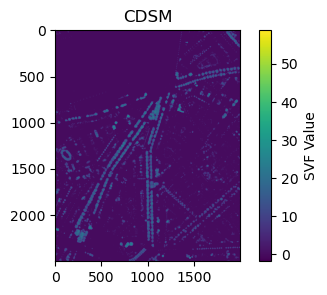

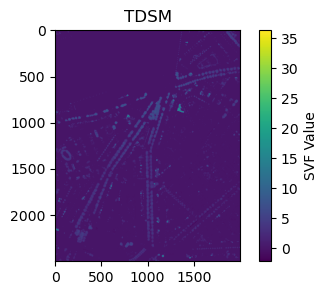

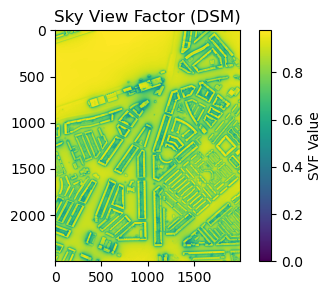

In [4]:
def main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir):
    """Main function to load data, calculate SVF, and save the results."""

    #See if GPU is initialized right
    cuda.init()
    printGPU()

    # Plot the SVFs
    def plot_svf(svf_data, title):
        plt.figure(figsize=(5, 3))
        plt.imshow(svf_data, cmap='viridis')
        plt.colorbar(label='SVF Value')
        plt.title(title)
        plt.show()
    
    # Load DSM and vegetation DEM using GDAL
    dsm_ds = gdal.Open(dsm_path)
    vegdem_ds = gdal.Open(vegdem_path)
    vegdem2_ds = gdal.Open(vegdem2_path)  # Load the canopy bottom DEM

    #Calculate scale from input DSM
    geotransform = dsm_ds.GetGeoTransform()
    scale = 1 / geotransform [1]
    
    dsm = dsm_ds.ReadAsArray().astype(np.float32)
    vegdem = vegdem_ds.ReadAsArray().astype(np.float32)
    vegdem2 = vegdem2_ds.ReadAsArray().astype(np.float32)  # Read the canopy bottom DEM

    # Add DSM height to vegetation heights
    vegdem = np.where(vegdem > 0, vegdem + dsm, vegdem)
    vegdem2 = np.where(vegdem2 > 0, vegdem2 + dsm, vegdem2)    

    # Apply Gaussian filter to vegdem
    vegdem = gaussian_filter(vegdem, sigma=0.5)
    vegdem2 = gaussian_filter(vegdem2, sigma=0.5)

    #Plot to see if CDSM/TDSM are loaded correctly
    plot_svf(vegdem, 'CDSM')
    plot_svf(vegdem2, 'TDSM')
    
    # Define svf_type mapping
    svf_type_mapping = {
        'dsm': 0,
        'veg': 1,
        'veg_blocking_buildings': 2
    }
    
    # Calculate SVFs on GPU
    svf_dsm = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['dsm'])
    #svf_veg = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['veg'])
    #svf_veg_blocking_buildings = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['veg_blocking_buildings'])
    
    # Save the results as GeoTIFFs
    driver = gdal.GetDriverByName('GTiff')

    def save_svf(filename, svf_data):
        out_ds = driver.Create(filename, dsm.shape[1], dsm.shape[0], 1, gdal.GDT_Float32)
        out_ds.GetRasterBand(1).WriteArray(svf_data)
        out_ds.SetGeoTransform(dsm_ds.GetGeoTransform())
        out_ds.SetProjection(dsm_ds.GetProjection())
        out_ds.FlushCache()

    # Generate a timestamp string
    timestamp = datetime.now().strftime("%H%M%S")

    # Modify the filenames to include the timestamp
    save_svf(f"{output_dir}/svf_dsm_{timestamp}.tif", svf_dsm)
    #save_svf(f"{output_dir}/svf_veg_{timestamp}.tif", svf_veg)
    #save_svf(f"{output_dir}/svf_veg_blocking_buildings_{timestamp}.tif", svf_veg_blocking_buildings)

    # Plot each SVF
    plot_svf(svf_dsm, 'Sky View Factor (DSM)')
    #plot_svf(svf_veg, 'Sky View Factor (Vegetation)')
    #plot_svf(svf_veg_blocking_buildings, 'Sky View Factor (Vegetation Blocking Buildings)')


if __name__ == "__main__":
    # Define file paths and parameters
    dsm_path = "C:/Users/Max/Documents/Werk/test_gpu/input/dsm_buildings_ground_37HN1_14.tif"       # DSM raster file path
    vegdem_path = "C:/Users/Max/Documents/Werk/test_gpu/input/cdsm_groundlvl_37HN1_14.tif"          # CDSM raster file path
    vegdem2_path = "C:/Users/Max/Documents/Werk/test_gpu/input/TDSM.tif"                            # TDSM raster file path
    transparency_factor = 0.97                                                                      # Transparency/opacity factor for vegetation impact
    output_dir = "C:/Users/Max/Documents/Werk/test_gpu/output/bigger_terr"                          # Output directory

    gdal.UseExceptions()
    main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir)